In [1]:
pip install datasets evaluate rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.0 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=cc059ec2e43c88f857ccb2d2ae43c1e3970ae35cb8e7b1f25fc7fb425c3dddd6
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's de

In [6]:
from datasets import load_dataset, load
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments, DataCollatorForSeq2Seq
import torch
import wandb
import evaluate
import numpy as np
from sklearn.metrics import accuracy_score


# Load dataset and limit to 1000 samples
dataset_train = load_dataset("ag_news", split='train[:1000]')  # Load first 1000 samples from training set
dataset_test = load_dataset("ag_news", split='test[:200]')    # Load first 1000 samples from test set

# Load pre-trained tokenizer and model
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')

# Load ROUGE metric
rouge = evaluate.load("rouge")

# Function to preprocess data: Tokenize inputs and labels
def preprocess_data(examples):
    inputs = [f"summarize: {article}" for article in examples['text']]
    targets = [str(label) for label in examples['label']]  # Ensure the labels are strings if they're not

    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding='max_length')
    labels = tokenizer(targets, max_length=512, truncation=True, padding='max_length')

    # Flatten labels to avoid nested lists
    model_inputs['labels'] = [label for label in labels['input_ids']]
    return model_inputs


# Apply preprocessing to datasets
tokenized_train = dataset_train.map(
    preprocess_data,
    batched=True,
    num_proc=4,
    remove_columns=["text", "label"]  # Adjust column names as per your dataset
)

tokenized_valid = dataset_test.map(
    preprocess_data,
    batched=True,
    num_proc=4,
    remove_columns=["text", "label"]  # Adjust column names as per your dataset
)

# Initialize Data Collator for Seq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Function to compute metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred.predictions[0], eval_pred.label_ids

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True,
        rouge_types=[
            'rouge1',
            'rouge2',
            'rougeL'
        ]
    )

    accuracy = accuracy_score(decoded_labels, decoded_preds)
    result["accuracy"] = accuracy

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}


def preprocess_logits_for_metrics(logits, labels):
    pred_ids = torch.argmax(logits[0], dim=-1)
    labels = labels.view(-1)  # Flatten labels if needed
    return pred_ids, labels


# Define Training Arguments
# training_args = TrainingArguments(
#     output_dir="./results",           # Output directory
#     evaluation_strategy="epoch",
#     fp16=True,# Evaluate after each epoch
#     learning_rate=0.0001,
#     gradient_accumulation_steps=2,# Learning rate
#     per_device_train_batch_size=4,    # Train batch size
#     per_device_eval_batch_size=4,     # Eval batch size
#     weight_decay=0.01,                # Weight decay for regularization
#     num_train_epochs=1,              # Number of epochs
#     logging_dir="./logs",             # Directory for logs
#     logging_steps=500,                # Log every 500 steps
#     # report_to="wandb",                # Enable Weights and Biases integration
#     save_strategy="epoch",            # Save the model every epoch
# )
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=200,
    save_strategy='epoch',
    save_total_limit=2,
    report_to='tensorboard',
    learning_rate=0.0001,
    dataloader_num_workers=4
)
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    # data_collator=data_collator,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    # tokenizer=tokenizer,
    compute_metrics=compute_metrics,  # Add compute_metrics function here
)

# Start W&B tracking
# wandb.init(project="your_project_name", entity="your_wandb_entity")

# Start training
trainer.train()

# Finish W&B tracking
# wandb.finish()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Accuracy,Gen Len
200,0.113800,0.086843,0.000000,0.000000,0.000000,0.000000,3.000000
400,0.043200,5.327483,0.000000,0.000000,0.000000,0.000000,512.000000
600,0.038100,9.650575,0.000000,0.000000,0.000000,0.000000,512.000000
800,0.021200,1.775252,0.000000,0.000000,0.000000,0.000000,512.000000
1000,0.018400,7.804994,0.000000,0.000000,0.000000,0.000000,512.000000
1200,0.015100,2.506534,0.000000,0.000000,0.000000,0.000000,512.000000
1400,0.019200,5.126865,0.000000,0.000000,0.000000,0.000000,512.000000
1600,0.013900,3.284194,0.000000,0.000000,0.000000,0.000000,512.000000
1800,0.013300,5.575156,0.000000,0.000000,0.000000,0.000000,512.000000
2000,0.012000,8.390131,0.000000,0.000000,0.000000,0.000000,512.000000


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=10000, training_loss=0.16559362284056842, metrics={'train_runtime': 2225.0674, 'train_samples_per_second': 4.494, 'train_steps_per_second': 4.494, 'total_flos': 1.083552301056e+16, 'train_loss': 0.16559362284056842, 'epoch': 10.0})

In [ ]:
SAVE_DIR = 'bart_model'

# Save the model
model.save_pretrained(SAVE_DIR)

# Save the tokenizer
tokenizer.save_pretrained(SAVE_DIR)

print(f"Model and tokenizer saved to {SAVE_DIR}")

Model and tokenizer saved to bart_model


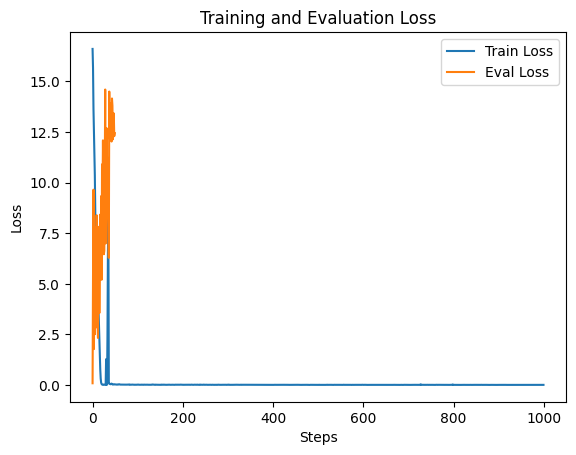

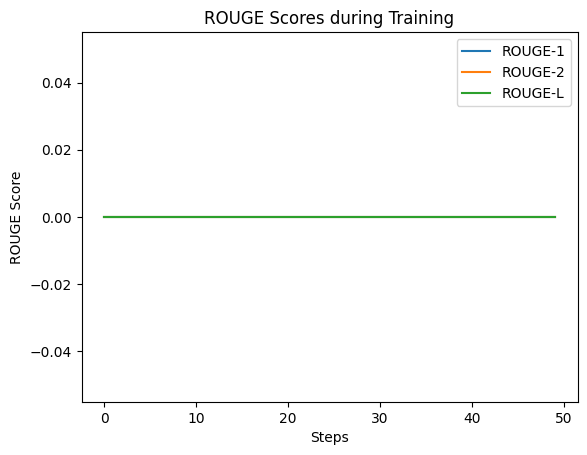

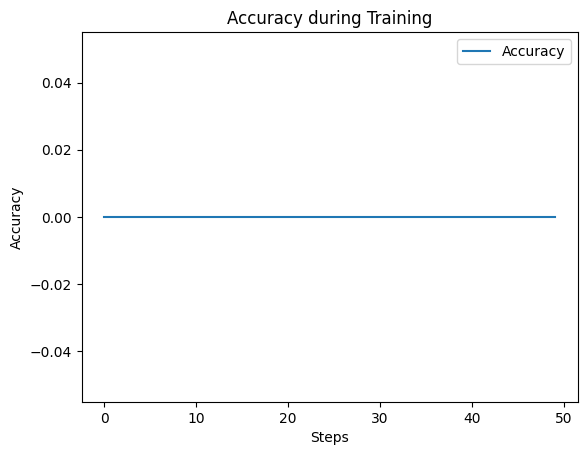

In [7]:
from transformers import Trainer, TrainingArguments
import matplotlib.pyplot as plt

# Access the log history for metrics like loss, accuracy, and ROUGE
log_history = trainer.state.log_history

# Extract specific metrics
train_loss = [entry['loss'] for entry in log_history if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
accuracy = [entry['eval_accuracy'] for entry in log_history if 'eval_accuracy' in entry]
rouge1 = [entry['eval_rouge1'] for entry in log_history if 'eval_rouge1' in entry]
rouge2 = [entry['eval_rouge2'] for entry in log_history if 'eval_rouge2' in entry]
rougeL = [entry['eval_rougeL'] for entry in log_history if 'eval_rougeL' in entry]

# Now you can plot these metrics using matplotlib
plt.plot(train_loss, label='Train Loss')
plt.plot(eval_loss, label='Eval Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.show()

plt.plot(rouge1, label='ROUGE-1')
plt.plot(rouge2, label='ROUGE-2')
plt.plot(rougeL, label='ROUGE-L')
plt.xlabel('Steps')
plt.ylabel('ROUGE Score')
plt.title('ROUGE Scores during Training')
plt.legend()
plt.show()

plt.plot(accuracy, label='Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Accuracy during Training')
plt.legend()
plt.show()


In [8]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
import numpy as np

# Load the tokenizer and model
# MODEL = 't5-base'
# tokenizer = T5Tokenizer.from_pretrained(MODEL)
# model = T5ForConditionalGeneration.from_pretrained(MODEL).to("cuda" if torch.cuda.is_available() else "cpu")

def sample_from_logits(logits, temperature=1.0, top_k=50):
    """
    Sample a token from the logits using temperature and top-k sampling.
    """
    logits = logits / temperature  # Apply temperature scaling
    logits = logits.cpu().detach().numpy()  # Convert logits to numpy array

    # Apply top-k sampling
    top_k_indices = np.argsort(logits)[-top_k:]  # Get top-k indices
    top_k_logits = logits[top_k_indices]  # Get top-k logits
    top_k_probs = np.exp(top_k_logits) / np.sum(np.exp(top_k_logits))  # Compute probabilities
    selected_token = np.random.choice(top_k_indices, p=top_k_probs)  # Sample a token

    return selected_token

def generate_summary(input_text, tokenizer, model2, max_input_len=512, max_output_len=128, temperature=1.0, top_k=50):
    """
    Generate a summary using the T5 model with sampling.
    """
    # Step 1: Tokenize the input text
    input_ids = tokenizer.encode(
        input_text,
        max_length=max_input_len,
        truncation=True,
        return_tensors='pt',
        padding='max_length'
    ).to(model.device)

    # Step 2: Generate predictions
    output = model.generate(
        input_ids=input_ids,
        max_length=max_output_len,
        do_sample=True,
        temperature=temperature,
        top_k=top_k,
        num_return_sequences=1
    )

    # Step 3: Decode the generated output
    generated_summary = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_summary

# Example usage
input_text = '''Years ago, my favorite cracker was Keebler Club. One day, I saw the multi-grain version and thought I’d try it,
    especially since I enjoy whole-grain breads and am trying to lower cholesterol. I couldn’t believe the multi-grain
    version actually tastes better than the original! I bought several boxes of these crackers and always keep some on hand.
    I use them for Asian tuna salad, with Inglehoffer sweet honey mustard, or as spreads for soups. They are tasty crackers.
'''

summary = generate_summary(input_text, tokenizer, model, max_input_len=400, max_output_len=100, temperature=0.7, top_k=50)
print("Generated Summary:", summary)


Generated Summary: 3021
